In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
import json
import re
import scipy as sp
import pickle

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.special import softmax
from scipy.sparse import csr_matrix

import random
random.seed(1234)

# Data loading and Processing

In [3]:
data_dir = '/Users/dare_devil/Documents/MLDS_2024/Quarter2/DataMining/Project/data'
os.listdir(data_dir)

['test_data.json',
 'user_profiles_bert.pkl',
 '.DS_Store',
 'dataset',
 'user_profiles.pkl',
 'item_profiles_bert.pkl',
 '.ipynb_checkpoints',
 'train_data.json',
 'archive.zip',
 'item_profiles.pkl']

In [4]:
# Filenames of the objects to be used
train_data_fname = 'train_data.json'
test_data_fname = 'test_data.json'
user_profiles_fname = 'user_profiles_bert.pkl'
item_profiles_fname = 'item_profiles_bert.pkl'

In [5]:
# Loading Training and Testing Data 
train_df = pd.read_json(os.path.join(data_dir, train_data_fname))
test_df = pd.read_json(os.path.join(data_dir, test_data_fname))

# Loading User and Item Profiles
user_profiles = pickle.load(open(os.path.join(data_dir, user_profiles_fname), 'rb'))
item_profiles = pickle.load(open(os.path.join(data_dir, item_profiles_fname), 'rb'))

In [6]:
# Defining User-Item Matrices and Mapping Functions
user_matrix = np.array([profile  for user_id, profile in user_profiles.items()])
item_matrix = np.array([profile  for item_id, profile in item_profiles.items()])


idx2user = { idx:user_id for idx,user_id in enumerate(user_profiles.keys())}
idx2item = { idx:item_id for idx,item_id in enumerate(item_profiles.keys())}

In [8]:
# Removing items from test set which are not present in train set
test_items = test_df['business_id'].unique()
train_items = train_df['business_id'].unique()

delete_items = []
for item in test_items:
  if item not in train_items:
    delete_items.append(item)


print(test_df.shape)
test_df = test_df[~test_df.business_id.isin(delete_items)]
print(test_df.shape)

print(f"Deleted Items: {len(delete_items)}")

(67278, 22)
(67101, 22)
Deleted Items: 164


In [9]:
# Filtering Test Dataframe based on number of reviews per user
review_per_user_thresh = 50

user_review_count = test_df.groupby('user_id')['review_id'].count().sort_values(ascending=False).reset_index()
user_review_count.rename(columns={'review_id' : 'num_reviews'}, inplace=True)

filtered_user_ids = user_review_count[user_review_count.num_reviews >= review_per_user_thresh].user_id

test_df_filtered = test_df[test_df.user_id.isin(filtered_user_ids)]
print("Filtered Test Dataframe Size :", test_df_filtered.shape[0])

Filtered Test Dataframe Size : 6832


In [13]:
# Defining Helper Functions
def evaluate_engine(test_df, topk, engine):
  y_true = np.array(test_df['user_rating'].tolist())
  y_pred = []

  failed_indices = []
  done=0
  total=test_df.shape[0]

  print("Starting Inference")
  for idx, row in test_df.iterrows():
    u_id = row['user_id']
    item_id = row['business_id']
    try:
      pred_rating = engine.predict(u_id, item_id, topk)
    except Exception as e:
      print(e)
      failed_indices.append(idx)
      continue
    y_pred.append(pred_rating)
    done+=1

    if done % 500 == 0:
      print(f"{done}/{total} Done | {len(failed_indices)}/{total} Failed")

  print("Removing Failed Indices")
  y_true = np.delete(y_true, failed_indices)

  mse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  print(f"mse@k={topk} : {mse}, mae@k={topk} : {mae}")
  print("Done")

  return mse, mae

# User Based Engine

In [14]:
# Defining User Based Recommendation Engine Class

class UserBasedEngine:
  def __init__(self, sim_matrix, idx2user, idx2item, train_df):
    """
    args:
      sim_matrix: user-user similarity matrix
      idx2user : index to user_id mapping
      idx2item : index to item_id mapping
      train_df : training dataframe
    """
    self.sim_matrix = sim_matrix
    self.idx2user = idx2user
    self.idx2item = idx2item
    self.train_df = train_df

    self.user2idx = {v:k for k,v in self.idx2user.items()}
    self.item2idx = {v:k for k,v in self.idx2item.items()}

  def predict(self, user_id, item_id, topk):
    """
    Given a user_id,item_id find users who have rated given item_id and find topk similar users
    args:
      user_id, item_id : pair of user_id and item_id for which rating is to predicted
      topk : number of nearest neighbours to consider
    """
    # Finding users who have rated item : item_id
    user_who_rated = self.train_df[self.train_df.business_id == item_id].user_id.unique()

    user_index = self.user2idx[user_id]
    sim_scores = self.sim_matrix[user_index]

    sim_scores = pd.Series(sim_scores)
    sim_scores.index = self.user2idx.keys()

    # Finding Similar users as user_id from the users who have rated
    sorted_sim_scores = sim_scores[user_who_rated].sort_values(ascending=False)

    # Appplying Softmax of Similarity scores
    topk_sims = softmax(sorted_sim_scores[:topk])
    topk_users = sorted_sim_scores[:topk].index

    filter_df = self.train_df[(self.train_df.business_id == item_id) & (self.train_df.user_id.isin(topk_users))]
    topk_ratings = [user_df['user_rating'].mean() for user_id, user_df in filter_df.groupby('user_id')]

    # Calculate weighted predicted rating
    predicted_rating = round(sum([ topk_sims[idx]*topk_ratings[idx] for idx in range(len(topk_ratings))]))


    assert predicted_rating >= 0.99 and predicted_rating <= 5.1, f"Predicted Rating : {predicted_rating} out of bounds"
    return predicted_rating

In [16]:
# Initializinng User Similarity Matrix
user_sim_matrix = cosine_similarity(user_matrix)
np.fill_diagonal(user_sim_matrix, 0)


ub_engine = UserBasedEngine(sim_matrix=user_sim_matrix,
                            idx2user = idx2user,
                            idx2item = idx2item,
                            train_df = train_df
                            )

In [17]:
KRange = [5, 10, 15, 20, 25]
mse_list = []
mae_list = []

for topk in KRange:
  print(f"Evaluating for topk = {topk}")
  mse, mae = evaluate_engine(test_df = test_df_filtered,
                             topk = topk,
                             engine = ub_engine
                             )
  mse_list.append(mse)
  mae_list.append(mae)

Evaluating for topk = 5
Starting Inference
500/6832 Done | 0/6832 Failed
1000/6832 Done | 0/6832 Failed
1500/6832 Done | 0/6832 Failed
2000/6832 Done | 0/6832 Failed
2500/6832 Done | 0/6832 Failed
3000/6832 Done | 0/6832 Failed
3500/6832 Done | 0/6832 Failed
4000/6832 Done | 0/6832 Failed
4500/6832 Done | 0/6832 Failed
5000/6832 Done | 0/6832 Failed
5500/6832 Done | 0/6832 Failed
6000/6832 Done | 0/6832 Failed
6500/6832 Done | 0/6832 Failed
Removing Failed Indices
mse@k=5 : 1.0042447306791569, mae@k=5 : 0.7015515222482436
Done
Evaluating for topk = 10
Starting Inference
500/6832 Done | 0/6832 Failed
1000/6832 Done | 0/6832 Failed
1500/6832 Done | 0/6832 Failed
2000/6832 Done | 0/6832 Failed
2500/6832 Done | 0/6832 Failed
3000/6832 Done | 0/6832 Failed
3500/6832 Done | 0/6832 Failed
4000/6832 Done | 0/6832 Failed
4500/6832 Done | 0/6832 Failed
5000/6832 Done | 0/6832 Failed
5500/6832 Done | 0/6832 Failed
6000/6832 Done | 0/6832 Failed
6500/6832 Done | 0/6832 Failed
Removing Failed Indic

Text(0.5, 1.0, 'MSE vs TopK')

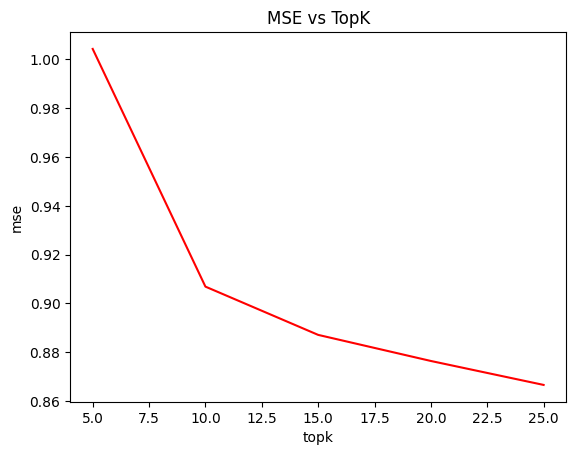

In [18]:
# Plotting MSE vs Topk Curve
plt.plot(KRange, mse_list, color='r')
plt.xlabel('topk')
plt.ylabel('mse')
plt.title('MSE vs TopK')

Text(0.5, 1.0, 'MAE vs TopK')

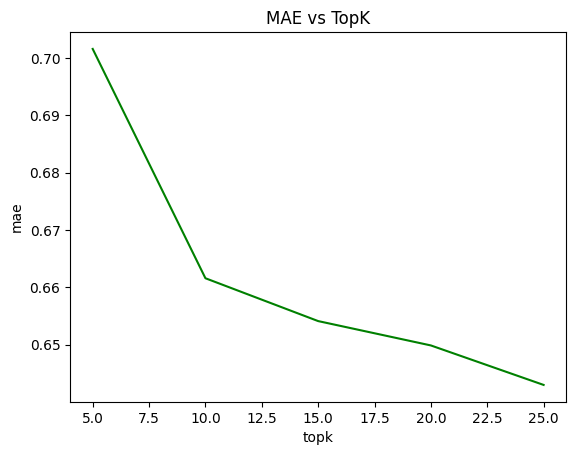

In [19]:
# Plotting MAE vs TopK Curve
plt.plot(KRange, mae_list, color='g')
plt.xlabel('topk')
plt.ylabel('mae')
plt.title('MAE vs TopK')

# Item Based Engine

In [20]:
class ItemBasedEngine:
  def __init__(self, sim_matrix, idx2user, idx2item, train_df):
    """
    params:
      sim_matrix : item-item similarity matrix
      idx2user : mapping of index to user_id
      idx2item : mapping of index to item_id
      train_df : training dataframe
    """
    self.sim_matrix = sim_matrix
    self.idx2user = idx2user
    self.idx2item = idx2item
    self.train_df = train_df

    self.user2idx = {v:k for k,v in self.idx2user.items()}
    self.item2idx = {v:k for k,v in self.idx2item.items()}

  def predict(self, user_id, item_id, topk):
    """
    Given a user_id,item_id find similar item that user has alreay used
    """
    # Finding Items given user has rated
    items_user_has_rated = self.train_df[self.train_df.user_id == user_id].business_id.unique()

    item_index = self.item2idx[item_id]
    sim_scores = self.sim_matrix[item_index]

    sim_scores = pd.Series(sim_scores)
    sim_scores.index = self.item2idx.keys()

    # Finding similarity of the given item with the items that user has rated
    sorted_sim_scores = sim_scores[items_user_has_rated].sort_values(ascending=False)

    topk_sims = softmax(sorted_sim_scores[:topk])
    topk_items = sorted_sim_scores[:topk].index

    filter_df = self.train_df[(self.train_df.user_id == user_id) & (self.train_df.business_id.isin(topk_items))]
    topk_ratings = [item_df['user_rating'].mean() for item_id, item_df in filter_df.groupby('business_id')]

    predicted_rating = sum([ topk_sims[idx]*topk_ratings[idx] for idx in range(len(topk_ratings))])
    assert predicted_rating >= 0.9 and predicted_rating <= 5.2, f"Predicted Rating : {predicted_rating} out of bounds"

    return predicted_rating

In [21]:
# Initializinng Item Similarity Matrix
item_sim_matrix = cosine_similarity(item_matrix)
np.fill_diagonal(item_sim_matrix, 0)


ib_engine = ItemBasedEngine(sim_matrix=item_sim_matrix,
                            idx2user = idx2user,
                            idx2item = idx2item,
                            train_df = train_df
                            )

In [22]:
KRange = [5, 10, 15, 20, 25]
mse_list = []
mae_list = []

for topk in KRange:
  print(f"Evaluating for topk = {topk}")
  mse, mae = evaluate_engine(test_df = test_df_filtered,
                             topk = topk,
                             engine = ib_engine
                             )
  mse_list.append(mse)
  mae_list.append(mae)

Evaluating for topk = 5
Starting Inference
500/6832 Done | 0/6832 Failed
1000/6832 Done | 0/6832 Failed
1500/6832 Done | 0/6832 Failed
2000/6832 Done | 0/6832 Failed
2500/6832 Done | 0/6832 Failed
3000/6832 Done | 0/6832 Failed
3500/6832 Done | 0/6832 Failed
4000/6832 Done | 0/6832 Failed
4500/6832 Done | 0/6832 Failed
5000/6832 Done | 0/6832 Failed
5500/6832 Done | 0/6832 Failed
6000/6832 Done | 0/6832 Failed
6500/6832 Done | 0/6832 Failed
Removing Failed Indices
mse@k=5 : 0.9296879954564037, mae@k=5 : 0.7450432345606202
Done
Evaluating for topk = 10
Starting Inference
500/6832 Done | 0/6832 Failed
1000/6832 Done | 0/6832 Failed
1500/6832 Done | 0/6832 Failed
2000/6832 Done | 0/6832 Failed
2500/6832 Done | 0/6832 Failed
3000/6832 Done | 0/6832 Failed
3500/6832 Done | 0/6832 Failed
4000/6832 Done | 0/6832 Failed
4500/6832 Done | 0/6832 Failed
5000/6832 Done | 0/6832 Failed
5500/6832 Done | 0/6832 Failed
6000/6832 Done | 0/6832 Failed
6500/6832 Done | 0/6832 Failed
Removing Failed Indic

Text(0.5, 1.0, 'MSE vs TopK')

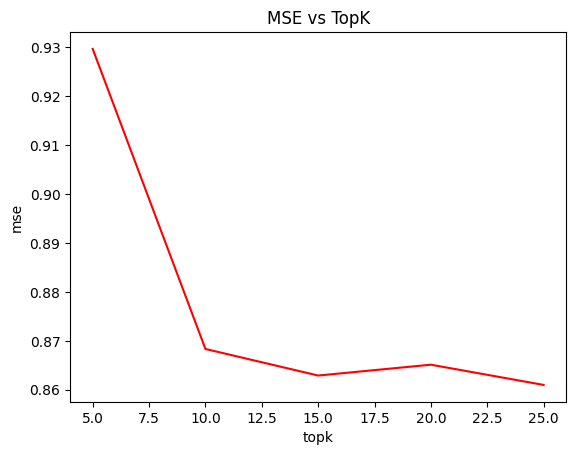

In [23]:
# Plotting MSE vs Topk Curve
plt.plot(KRange, mse_list, color='r')
plt.xlabel('topk')
plt.ylabel('mse')
plt.title('MSE vs TopK')

Text(0.5, 1.0, 'MAE vs TopK')

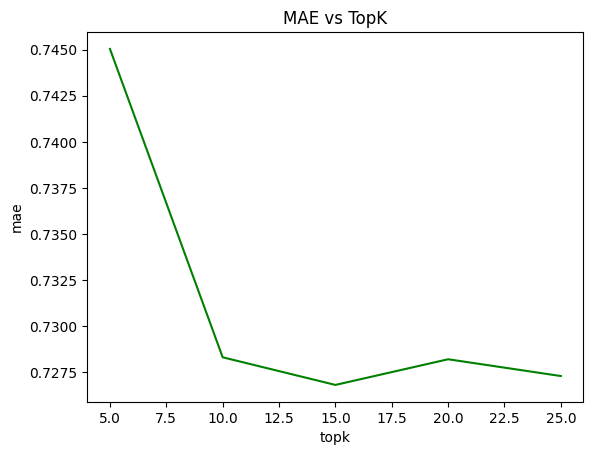

In [24]:
# Plotting MAE vs TopK Curve
plt.plot(KRange, mae_list, color='g')
plt.xlabel('topk')
plt.ylabel('mae')
plt.title('MAE vs TopK')